In [1]:
import numpy as np 
import pandas as pd 
import os
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import random
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
# import os
# import torch
# import torchvision.transforms as transforms
# from torchvision.datasets import ImageFolder
# from PIL import Image
# import random

# dataset_path = "/kaggle/input/thermal-images-diseased-healthy-leaves-paddy/thermal images UL"
# augmented_dataset_path = "/kaggle/working/augmented_dataset"  
# possible_augmentations = [
#     transforms.RandomHorizontalFlip(p=1.0),  
#     transforms.RandomRotation(degrees=30),  
#     transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  
#     transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),  
#     transforms.RandomPerspective(distortion_scale=0.4, p=1.0),  
#     transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 3.0)),  
# ]

# original_dataset = ImageFolder(root=dataset_path)
# if not os.path.exists(augmented_dataset_path):
#     os.makedirs(augmented_dataset_path)

# for class_name in original_dataset.classes:
#     os.makedirs(os.path.join(augmented_dataset_path, class_name), exist_ok=True)

# num_augmentations = 8  
# for img_path, label in original_dataset.samples:
#     img = Image.open(img_path).convert("RGB")
#     class_name = original_dataset.classes[label]
#     save_dir = os.path.join(augmented_dataset_path, class_name)

#     img.save(os.path.join(save_dir, os.path.basename(img_path)))
#     for i in range(num_augmentations):
#         selected_augmentations = random.sample(possible_augmentations, k=random.randint(1, 3)) 
#         transform_pipeline = transforms.Compose([transforms.Resize((227, 227))] + selected_augmentations)  
        
#         augmented_img = transform_pipeline(img)
#         save_path = os.path.join(save_dir, f"aug_{i}_{os.path.basename(img_path)}")
#         augmented_img.save(save_path)

# print(f"Dataset is completely augmented ")

In [3]:
# import shutil
# import os

# def zip_folder(folder_path, output_zip_path):
#     if not os.path.exists(folder_path):
#         print(f"Error: The folder '{folder_path}' does not exist.")
#         return
#     shutil.make_archive(output_zip_path, 'zip', folder_path)
#     print(f"Folder '{folder_path}' has been zipped to '{output_zip_path}.zip'")

# zip_folder("/kaggle/working/augmented_dataset", "/kaggle/working/augmented_dataset_zip_file")
# print(f"successfully zipped")

In [4]:
augmented_dataset_path = "/kaggle/input/thermal-dataset"

In [5]:
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((227, 227)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
augmented_dataset = ImageFolder(root=augmented_dataset_path, transform=transform)
train_size = int(0.6 * len(augmented_dataset))
val_size = int(0.2 * len(augmented_dataset))
test_size = len(augmented_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(augmented_dataset, [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[6].in_features 
num_classes = 6  
model.classifier[6] = nn.Linear(num_ftrs, num_classes)

for param in model.parameters():
    param.requires_grad = False
for param in model.classifier[6].parameters():
    param.requires_grad = True

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.0001)
scaler = torch.amp.GradScaler()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

num_epochs = 70
train_acc_history = []
val_acc_history = []
test_acc_history = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.amp.autocast(device_type="cuda"):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    print(f"Loss: {running_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

torch.save(model.state_dict(), "vggnet_trained.pth")
print("\n Model saved as alexnet_trained.pth")

Using device: cuda


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 235MB/s]


Loss: 1.5955, Accuracy: 33.78%
Loss: 1.4086, Accuracy: 42.28%
Loss: 1.3021, Accuracy: 48.25%
Loss: 1.2407, Accuracy: 51.98%
Loss: 1.1786, Accuracy: 54.54%
Loss: 1.1440, Accuracy: 55.88%
Loss: 1.1115, Accuracy: 57.95%
Loss: 1.0892, Accuracy: 58.82%
Loss: 1.0636, Accuracy: 60.02%
Loss: 1.0481, Accuracy: 59.93%
Loss: 1.0344, Accuracy: 61.15%
Loss: 1.0099, Accuracy: 62.58%
Loss: 1.0161, Accuracy: 60.83%
Loss: 0.9876, Accuracy: 62.58%
Loss: 0.9876, Accuracy: 62.55%
Loss: 0.9709, Accuracy: 63.69%
Loss: 0.9546, Accuracy: 63.89%
Loss: 0.9533, Accuracy: 63.92%
Loss: 0.9455, Accuracy: 64.24%
Loss: 0.9399, Accuracy: 63.72%
Loss: 0.9341, Accuracy: 65.49%
Loss: 0.9230, Accuracy: 65.73%
Loss: 0.9028, Accuracy: 66.42%
Loss: 0.9149, Accuracy: 64.91%
Loss: 0.9075, Accuracy: 65.38%
Loss: 0.8954, Accuracy: 65.55%
Loss: 0.9054, Accuracy: 65.93%
Loss: 0.8838, Accuracy: 66.66%
Loss: 0.8823, Accuracy: 66.69%
Loss: 0.8770, Accuracy: 66.89%
Loss: 0.8644, Accuracy: 67.91%
Loss: 0.8880, Accuracy: 66.28%
Loss: 0.

In [7]:
import numpy as np
import torch

class_names = augmented_dataset.classes  
num_classes = len(class_names)  

def calculate_per_class_accuracy(model, data_loaders, device, datasets=["Training", "Validation", "Test"]):
    for dataset_type, data_loader in zip(datasets, data_loaders):
        model.eval()
        class_correct = np.zeros(num_classes) 
        class_total = np.zeros(num_classes)

        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)

                for i in range(len(labels)):
                    label = labels[i].item()
                    class_correct[label] += (predicted[i] == label).item()
                    class_total[label] += 1

        print(f"\n Final Per-Class {dataset_type} Accuracy:\n")
        for i in range(num_classes):  
            if class_total[i] > 0:
                accuracy = 100 * class_correct[i] / class_total[i]
                print(f"{class_names[i]}: {dataset_type} = {accuracy:.2f}%")
            else:
                print(f"{class_names[i]}: {dataset_type} = No samples available ")

data_loaders = [train_loader, val_loader, test_loader]
datasets = ["Training", "Validation", "Test"]
calculate_per_class_accuracy(model, data_loaders, device, datasets=datasets)


 Final Per-Class Training Accuracy:

BLB: Training = 90.87%
Blast: Training = 53.44%
healthy: Training = 86.14%
hispa: Training = 76.73%
leaf folder: Training = 95.53%
leaf spot: Training = 64.45%

 Final Per-Class Validation Accuracy:

BLB: Validation = 85.13%
Blast: Validation = 30.08%
healthy: Validation = 78.29%
hispa: Validation = 63.84%
leaf folder: Validation = 89.66%
leaf spot: Validation = 50.00%

 Final Per-Class Test Accuracy:

BLB: Test = 84.22%
Blast: Test = 37.61%
healthy: Test = 78.89%
hispa: Test = 69.49%
leaf folder: Test = 82.61%
leaf spot: Test = 52.24%


Test Accuracy: 71.29%


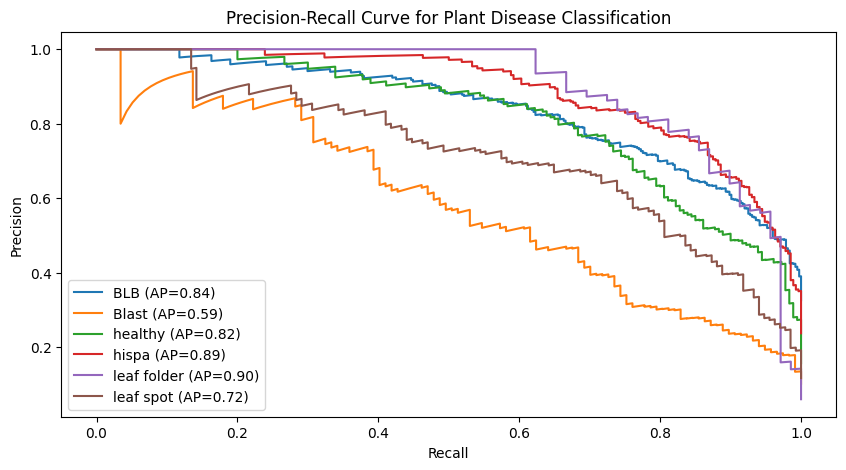

In [8]:
import numpy as np
import torch
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
y_true = []
y_scores = []
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        
        y_true.extend(labels.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)

plt.figure(figsize=(10, 5))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_true == i, y_scores[:, i])
    avg_precision = average_precision_score(y_true == i, y_scores[:, i])
    plt.plot(recall, precision, label=f"{class_names[i]} (AP={avg_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Plant Disease Classification")
plt.legend()
plt.show()

In [9]:
""" 

UNet, Resnet, SegNet, GoogleNet, VGG, AlexNet, IncepTon V3, R-CNN, YOLOv11,
ViT, EfficientNetv2
"""

' \n\nUNet, Resnet, SegNet, GoogleNet, VGG, AlexNet, IncepTon V3, R-CNN, YOLOv11,\nViT, EfficientNetv2\n'

In [10]:
# alexnet , resnet , googlenet , unet , vgg
# segnet , inception , rcnn , vit  , efficient net